In [109]:
import os
from dotenv import load_dotenv
load_dotenv()
GROQ_API_KEY=os.getenv("GROQ_API_KEY")
CHROMADB_API_KEY=os.getenv("CHROMADB_API_KEY")
TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"]=GROQ_API_KEY
os.environ["CHROMADB_API_KEY"]=CHROMADB_API_KEY
os.environ["TAVILY_API_KEY"]=TAVILY_API_KEY

In [110]:
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.document_loaders import JSONLoader
from langchain_core.documents import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter 

### jq_schema = """
    .[] |
    {
        content: (
            "Faculty: " + .faculty + "\\n" +
            "Subject: " + (.subject // "N/A") + "\\n" +
            "Branch: " + (.branch // "N/A") + "\\n" +
            "Year: " + (.year_teach // "N/A") + "\\n" +
            "Location: " + (.location // "N/A") + "\\n" +
            "Advantages: " + (.advantages // "N/A") + "\\n" +
            "Disadvantages: " + (.disadvantages // "N/A") + "\\n" +
            "Achievements: " + .achievements
        ),
        metadata: {
            faculty: .faculty
        }
    }
"""
###

In [112]:
# Loading the database of faculty present in Teacher_data.json
# Initiating the loader 

file_path="C:\\Users\\HVS\\OneDrive\\Desktop\\Chatbot\\Data\\Teacher_data.json"

loader = JSONLoader(
    file_path=file_path,#takes the file path of data
    #jq_schema provide schema of the whole database
     jq_schema = """
.[] | {
    content: (
        "Faculty: " + .faculty + "\\n" +
        "Subjects: " + (.subject | join(", ")) + "\\n" +
        "Branch: " + .branch + "\\n" +
        "Years Taught: " + (.year_teach | join(", ")) + "\\n" +
        "Location: " + .location + "\\n" +
        "Advantages: " + .advantages + "\\n" +
        "Disadvantages: " + .disadvantages + "\\n" +
        "Achievements: " + (.achievements | join("; "))
    ),
    metadata: {
        faculty: .faculty,
        branch: .branch,
        location: .location
    }
}
""",content_key="content"
)

#loader is the list of dictionary
data=loader.load()
print(type(data))
print(data[1])
print(data)
print(data[0].page_content)
print(data[0].metadata)


<class 'list'>
page_content='Faculty: Mr. Abhishek Malviya
Subjects: 
Branch: 
Years Taught: 
Location: 
Advantages: 
Disadvantages: 
Achievements: Nexus Connecting Hoomans, Rivista Italiana di Filosofia Analitica Junior, ESCI 2023 Virtual U; Robust Voice Assistant using Gaussian Mixture Model, Journal of Harbin Engineering University, Scopus-2023' metadata={'source': 'C:\\Users\\HVS\\OneDrive\\Desktop\\Chatbot\\Data\\Teacher_data.json', 'seq_num': 2}
[Document(metadata={'source': 'C:\\Users\\HVS\\OneDrive\\Desktop\\Chatbot\\Data\\Teacher_data.json', 'seq_num': 1}, page_content='Faculty: Mr. Abdul Zeeshan\nSubjects: \nBranch: \nYears Taught: \nLocation: \nAdvantages: \nDisadvantages: \nAchievements: A research paper presented in 3rdIEEE International Conference on Power Electronics & IOT Applications in Renewable Energy and its Control (PARC 2024), titled, "Fuzzy/ANFIS control of DFIG based wind energy conversion system under the condition of voltage sag on grid in one phase" on 23rd F

In [ ]:
# Creating chunks of the json file which is now "data"
# Doing RecursiveCharacterTextSplitter on the data to get the semantic search reasonable 
# so to get the full word not the half words
splitter = RecursiveCharacterTextSplitter(chunk_size=1200,chunk_overlap=0)
splitted_docs=splitter.split_documents(data)

In [ ]:
print(type(splitted_docs))
print(len(splitted_docs))
print(splitted_docs)
print(splitted_docs[0])
print(splitted_docs[0].metadata)
print(splitted_docs[0].page_content)

<class 'list'>
70
[Document(metadata={'source': 'C:\\Users\\HVS\\OneDrive\\Desktop\\Chatbot\\Data\\Teacher_data.json', 'seq_num': 1}, page_content='Faculty: Mr. Abdul Zeeshan\nSubjects: \nBranch: \nYears Taught: \nLocation: \nAdvantages: \nDisadvantages: \nAchievements: A research paper presented in 3rdIEEE International Conference on Power Electronics & IOT Applications in Renewable Energy and its Control (PARC 2024), titled, "Fuzzy/ANFIS control of DFIG based wind energy conversion system under the condition of voltage sag on grid in one phase" on 23rd February 2024, organized by GLA University, Mathura, Uttar Pradesh, India'), Document(metadata={'source': 'C:\\Users\\HVS\\OneDrive\\Desktop\\Chatbot\\Data\\Teacher_data.json', 'seq_num': 2}, page_content='Faculty: Mr. Abhishek Malviya\nSubjects: \nBranch: \nYears Taught: \nLocation: \nAdvantages: \nDisadvantages: \nAchievements: Nexus Connecting Hoomans, Rivista Italiana di Filosofia Analitica Junior, ESCI 2023 Virtual U; Robust Voice

In [ ]:
# loading the llm model here loading the groq llm model here and using gemma2-9b-it
# using embedder from hugging face using sentence transformer(BERT ARCHITECTURE) using all-MiniLM-L6-v2

from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model
from langchain.vectorstores import Chroma

model_name="sentence-transformers/all-MiniLM-L6-v2"
embeddings=HuggingFaceEmbeddings(model=model_name)

model_name="gemma2-9b-it"
llm = ChatGroq(model=model_name,temperature=0.6)
llm = init_chat_model("groq:gemma2-9b-it")

result=embeddings.embed_query("hello world")
print(len(result))

# storing the embedded data to our vector storage using ChromaDB and embedding using is hugging face embedder sentence transformer

vector_store=Chroma.from_documents(splitted_docs,
                                      embeddings,
                                      persist_directory="./Data")
print(type(vector_store))

retriever=vector_store.as_retriever(search_type="mmr",search_kwargs={'k':5})

384
<class 'langchain_community.vectorstores.chroma.Chroma'>


In [ ]:
print(retriever)
retriever.invoke("kumar dwivedi")

tags=['Chroma', 'HuggingFaceEmbeddings'] vectorstore=<langchain_community.vectorstores.chroma.Chroma object at 0x0000022716108260> search_type='mmr' search_kwargs={'k': 5}


[Document(metadata={'source': 'C:\\Users\\HVS\\OneDrive\\Desktop\\Chatbot\\Data\\Teacher_data.json', 'seq_num': 56}, page_content="Location: D Block Ground Floor\nAdvantages: Vijay kumar Dwivedi is a teacher whom Students prefer them the best teacher in machine learning,The best part about him that whenever you call him he'll pick up your call solve your problems."),
 Document(metadata={'source': 'C:\\Users\\HVS\\OneDrive\\Desktop\\Chatbot\\Data\\Teacher_data.json', 'seq_num': 7}, page_content='Singh, Amit Kumar Singh, Abhishek Kumar Tripathi and Prateek Pandey'),
 Document(metadata={'source': 'C:\\Users\\HVS\\OneDrive\\Desktop\\Chatbot\\Data\\Teacher_data.json', 'seq_num': 58}, page_content='DFIG" on 10th March 2024, jointly organized by NIT Kurukshetra, NIT Delhi & NPTI, India'),
 Document(metadata={'seq_num': 22, 'source': 'C:\\Users\\HVS\\OneDrive\\Desktop\\Chatbot\\Data\\Teacher_data.json'}, page_content='Faculty: Mr. Deeptanshu Dwivedi\nSubjects: \nBranch: \nYears Taught: \nLocat

In [ ]:
docs = retriever.invoke("Vijay Kumar Dwivedi achievements")
for d in docs:
    print(d.page_content)

Location: D Block Ground Floor
Advantages: Vijay kumar Dwivedi is a teacher whom Students prefer them the best teacher in machine learning,The best part about him that whenever you call him he'll pick up your call solve your problems.
Faculty: Mr. Vijay Kumar Dwivedi
Subjects: Machine Learning, Deep Learning, Artificial Intelligence
Branch: Computer Science and Engineering
Years Taught: 3rd, 4th
Location: D Block Ground Floor
Singh, Amit Kumar Singh, Abhishek Kumar Tripathi and Prateek Pandey
DFIG" on 10th March 2024, jointly organized by NIT Kurukshetra, NIT Delhi & NPTI, India
Faculty: Mr. Saurabh Jaiswal
Subjects: 
Branch: 
Years Taught: 
Location: 
Advantages: 
Disadvantages: 
Achievements: Attended NPTEL workshop at IIT Kanpur in Feb; 2024


from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever=retriever,
    name="UGI_TOOLS",
    description=
        
     """
     Use this tool when users ask about UGI faculty members. This tool helps you find information about:
    - Faculty names, subjects they teach, and their departments/branches
    - Years of teaching experience and campus locations
    - Teaching strengths, advantages, and areas for improvement
    - Academic achievements, research papers, conference presentations, and patents
    
    After retrieving information, present it in a friendly, conversational manner as if you're 
    personally familiar with the faculty members. Add context and personality to the responses.
    
    """                
            
)

print(type(retriever_tool))

retriever_tool.invoke({"query":"which teacher is best in machine learning "})

In [ ]:
from langchain.chains import RetrievalQA, create_history_aware_retriever
from langchain.prompts import PromptTemplate

model_name="gemma2-9b-it"
llm = ChatGroq(model=model_name,temperature=0.6)
llm = init_chat_model("groq:gemma2-9b-it")

prompt_template = PromptTemplate(
    template="""
Use this tool when users ask about UGI faculty members. This tool helps you find information about:
    - Faculty names, subjects they teach, and their departments/branches
    - Years of teaching experience and campus locations
    - Teaching strengths, advantages, and areas for improvement
    - Academic achievements, research papers, conference presentations, and patents

After retrieving information, present it in a friendly, conversational manner as if you're 
personally familiar with the faculty members. Add context and personality to the responses.

Context: {context}

Question: {question}
Answer:
""",
    input_variables=["context", "question"]
)

retrieverQA_tool = RetrievalQA.from_llm(
    llm=llm,
    retriever=retriever,
    prompt=prompt_template,
    return_source_documents=True
)

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from langchain_tavily import TavilySearch
from langgraph.prebuilt import ToolNode
from langchain_core.tools import tool


llm=init_chat_model("groq:gemma2-9b-it",temperature=0.6)

tavily_tool = TavilySearch(max_results=2)

print(tavily_tool.invoke("prime minister"))
print(type(tavily_tool.invoke("prime minister")))


#node functionality
class State(TypedDict):
    # State here is like a message passing from one node to another
    # Messages have the type list. the add_messages is a function to append messages.
    # annotation defines how the state key should be updated here it is appending like a list.
    # here in this case it appends message to the list rather than updating with help of add_messages function.
    messages: Annotated[list, add_messages]

#creating thr tavily search tool
@tool
def tool_calling_tavily(query:str):
     """
     A general-purpose web search tool powered by Tavily. 
     Use this tool for answering queries about topics that are not related to UGI faculty members, 
     such as current events, AI models, technology, research trends, and other general knowledge. 
     It searches the internet to provide up-to-date, relevant, and factual information.
     """
     return tavily_tool.invoke(query)

@tool
def tool_calling_retriever(query: str) -> str:
    """
    A specialized tool for answering questions about UGI faculty members.
    Uses a retrieval-based QA system to get accurate, context-rich answers.
    """
    return retrieverQA_tool.invoke(query)


llm_with_tools=llm.bind_tools([tool_calling_retriever,tool_calling_tavily],
                              )


def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}


#creating a tool node which has all the tools
tools = ToolNode([tool_calling_retriever,tool_calling_tavily])


{'query': 'prime minister', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://en.wikipedia.org/wiki/Prime_minister', 'title': 'Prime minister', 'content': 'A prime minister is not the head of state, but rather the head of government, serving as the chief of the executive under either a monarch or a president "President (government title)") in a republican form of government. In parliamentary systems of government (be they constitutional monarchies or parliamentary republics), the Prime Minister (or occasionally a similar post with a different title, such as the Chancellor of Germany) is the most powerful politician and the functional leader of the state, by virtue of commanding the confidence of the legislature. They both had an official title of Grand Vizier simply the Head of the Government which is called Prime Minister nowadays.', 'score': 0.98564, 'raw_content': None}, {'url': 'https://en.wikipedia.org/wiki/Prime_Minister_of_the_United_Kingdom

-->But state is a dictionary containing messages, not a plain query string.

-->TavilySearch.invoke() expects a string query, like "prime minister", not a dict.

O--> Why this breaks
Your state looks like:

{
    "messages": [HumanMessage(content="Who is the prime minister?"), ...]
}

O-->When you pass {"messages": state}, Tavily gets:

{"messages": {"messages": [HumanMessage(...)]}}

-->Tool functions → match inputs to what you want the LLM to provide (simple types are best).

-->Node functions → accept State and work directly with conversation history.


In [ ]:
from langgraph.graph import StateGraph
from langgraph.graph import START,END
from langgraph.prebuilt import tools_condition

builder=StateGraph(State)

#node
builder.add_node("llm_with_tools",tool_calling_llm)
builder.add_node("collection_tools",tools)

#edge
builder.add_edge(START,"llm_with_tools")
builder.add_conditional_edges("llm_with_tools",tools_condition,
                              {
# IF the latest message(result) from assistant(LLM) is a tool call--> tools condition routes to tools node(collection_tools)
# IF the latest message(result) from assistant(LLM)is not a tool call --> tools condition routes to end
                                  "tools":"collection_tools",
                                  END:END
                              }
                              )

graph=builder.compile()


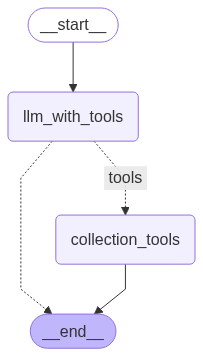

In [ ]:
from IPython.display import display, Image

Image(graph.get_graph().draw_mermaid_png())

In [ ]:
response = graph.stream({"messages" : [{"role":"user" , "content":"nandita pradhan and 2+2"}]},stream_mode="values")
for m in response:
    m["messages"][-1].pretty_print()

# In graph the state graph also takes state in which the state is a dictionary

================================ Human Message =================================

nandita pradhan and 2+2
================================== Ai Message ==================================

<tool-call>
{
	"tool_call": {
		"id": "pending",
		"type": "function",
		"function": {
			"name": "tool_calling_tavily"
		},
		"parameters": {
			"query": "what is 2 plus 2"
		}
	}
}
</tool-call>


In [ ]:
response=graph.invoke({"messages":"what are the achievements of praveen sir and then tell me what are the current advantages of GPT-5?"})
print(response)
print("\n")
print(type(response))
print("\n")
print(response["messages"])
print("\n")
print(response["messages"][-1])
print("\n")
print(response["messages"][-1].content)
print("\n")
for m in response["messages"]:
    m.pretty_print()

{'messages': [HumanMessage(content='what are the achievements of praveen sir and then tell me what are the current advantages of GPT-5?', additional_kwargs={}, response_metadata={}, id='ee0fb729-d666-48fc-995a-77f142248f9d'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '8sxdmsn4j', 'function': {'arguments': '{"query":"What are the achievements of Praveen sir?"}', 'name': 'tool_calling_retriever'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 91, 'prompt_tokens': 1156, 'total_tokens': 1247, 'completion_time': 0.165454545, 'prompt_time': 0.024389388, 'queue_time': 0.264200312, 'total_time': 0.189843933}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--46a2b9c1-14f2-494a-8c0e-fef4d0e640d1-0', tool_calls=[{'name': 'tool_calling_retriever', 'args': {'query': 'What are the achievements of Praveen sir?'}, 'id': '8sxdmsn4j', 'type': '

### The Above graph shows tha it working on our data well but not react to other query so
### to create the Bot agentic we have to use ReAct architecture or agent which Give birth to Agentic Ai


### ReAct Agent --->

In [ ]:
from langgraph.graph import StateGraph
from langgraph.graph import START,END
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import InMemorySaver

builder=StateGraph(State)

#node

builder.add_node("llm_with_tools",tool_calling_llm)
builder.add_node("collection_tools",tools)

#edge
builder.add_edge(START,"llm_with_tools")
builder.add_conditional_edges("llm_with_tools",tools_condition,
                              {  
# IF the latest message(result) from assistant(LLM) is a tool call--> tools condition routes to tools node(collection_tools)
# IF the latest message(result) from assistant(LLM)is not a tool call --> tools condition routes to end
                                  "tools":"collection_tools",
                                   END:END
                              }
                              )
                                
builder.add_edge("collection_tools","llm_with_tools")
#checkpointer_memory =InMemorySaver()
graph=builder.compile()


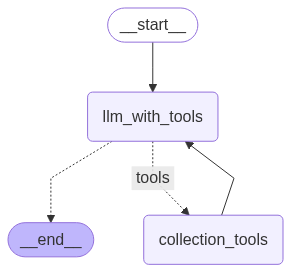

In [ ]:
Image(graph.get_graph().draw_mermaid_png())

In [ ]:
response = graph.invoke({"messages":"what are advantages and disadvantages of Sharad sir and the tell me disadvantages of vijay sir ?"})

for m in response["messages"]:
    m.pretty_print()

response = graph.stream({"messages" : [{"role":"user" , "content":"what subjects sharad sir teach and then tell me value of 2+2"}]},stream_mode="values")
for m in response:
    m["messages"][-1].pretty_print()

================================ Human Message =================================

what are advantages and disadvantages of Sharad sir and the tell me disadvantages of vijay sir ?
================================== Ai Message ==================================
Tool Calls:
  tool_calling_retriever (n686rr32h)
 Call ID: n686rr32h
  Args:
    query: What are the advantages and disadvantages of Sharad sir and the tell me disadvantages of vijay sir ?
================================= Tool Message =================================
Name: tool_calling_retriever

{'query': 'What are the advantages and disadvantages of Sharad sir and the tell me disadvantages of vijay sir ?', 'result': "Alright, let's talk about Mr. Sharad Chand Srivastava. \n\nHe's known for being a really friendly guy and always willing to help students. If you're struggling with something, he'll definitely make time to sort it out for you.  He's also a rockstar when it comes to his core subject, Fundamentals of Mechanical Engi

### THIS WHOLE ABOVE IS AN AGENT AS IT HAS THE ReAct CAPABILITIES TO ACT , TO OBSERVE, TO REASON THIS WAY I HAVE CREATED THE ONE SIMPLE AGENT WITH ReAct CAPABILITIES THAT CAN BE USED TO BUILD OTHER AGENTS WITH ReAct ABILITIES.

### BUT TO CREATE AN AGENT THIS WAY IS HECTIC SO LANGGRAPH PROVIDES FUNCTION CALLED create_agent() WITH THE HELP OF THIS FUNCTION I CAN CREATE THE AGENT WITH ReAct ABILITIES